<a href="https://colab.research.google.com/github/thu-soccer/project/blob/master/colab/colab_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow_core.estimator import inputs
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import load_model


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import math

import pathlib
import shutil
import tempfile


def normalize_and_encode(dataframe):
    column_names_to_not_normalize = ['result']
    column_names_to_normalize = [x for x in list(dataframe) if x not in column_names_to_not_normalize ]
    x = dataframe[column_names_to_normalize].values
    x_scaled = preprocessing.normalize(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = dataframe.index)
    dataframe[column_names_to_normalize] = df_temp

    le = preprocessing.LabelEncoder()
    le.fit([ "H", "A", "D"])
    dataframe.loc[:,['result']]=le.transform(dataframe['result'])
    
    return dataframe

def get_X_and_y(dataframe):
    X = dataframe.drop(columns=['result']).values
    y = dataframe[['result']].values
    return X,y

df01 = pd.read_csv('../data/sliding01.csv', sep=',', index_col=0)
df02 = pd.read_csv('../data/sliding02_shots.csv', sep=',', index_col=0)
df03 = pd.read_csv('../data/sliding03_shots_extra.csv', sep=',', index_col=0)
df04 = pd.read_csv('../data/sliding04_shots_and_possession.csv', sep=',', index_col=0)
df05 = pd.read_csv('../data/sliding05_shots_and_possession_extra.csv', sep=',', index_col=0)

n01 = normalize_and_encode(df01)
n02 = normalize_and_encode(df02)
n03 = normalize_and_encode(df03)
n04 = normalize_and_encode(df04)
n05 = normalize_and_encode(df05)

train01, test01 = train_test_split(n01, test_size=0.05)
print(len(train01), 'train examples')
print(len(test01), 'test examples')

train02, test02 = train_test_split(n02, test_size=0.05)
print(len(train02), 'train examples')
print(len(test02), 'test examples')

train03, test03 = train_test_split(n03, test_size=0.05)
print(len(train03), 'train examples')
print(len(test03), 'test examples')

train04, test04 = train_test_split(n04, test_size=0.05)
print(len(train04), 'train examples')
print(len(test04), 'test examples')

train05, test05 = train_test_split(n05, test_size=0.05)
print(len(train04), 'train examples')
print(len(test04), 'test examples')

train_X01,train_y01 = get_X_and_y(train01)
train_X02,train_y02 = get_X_and_y(train02)
train_X03,train_y03 = get_X_and_y(train03)
train_X04,train_y04 = get_X_and_y(train04)
train_X05,train_y05 = get_X_and_y(train05)

test_X01,test_y01 = get_X_and_y(test01)
test_X02,test_y02 = get_X_and_y(test02)
test_X03,test_y03 = get_X_and_y(test03)
test_X04,test_y04 = get_X_and_y(test04)
test_X05,test_y05 = get_X_and_y(test05)


#Many models train better if you gradually reduce the learning rate during training. Use optimizers.schedules to reduce the learning rate over time:
#The code sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

def get_lr_schedule(train, batch_size):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=(len(train)//batch_size)*1000,
    decay_rate=1,
    staircase=False)
    return lr_schedule

def get_optimizer(train, batch_size):
    return tf.keras.optimizers.Adam(get_lr_schedule(train, batch_size))


#Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.
#The training for this tutorial runs for many short epochs. To reduce the logging noise use the tfdocs.EpochDots which simply a . for each epoch and, and a full set of metrics every 100 epochs.

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
        #tf.keras.callbacks.TensorBoard(logdir/name), # Jupyter Notebook
        #tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1) # Google Colab
      ]

def compile_and_fit(model, name, X, y, validation_split, batch_size, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer(X, batch_size)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()
     
    history = model.fit(
        X,
        y,
        validation_split=validation_split,
        batch_size=batch_size,
#        steps_per_epoch = 50, # (len(train_X01)//batch_size,
        epochs=max_epochs,
        callbacks=get_callbacks(name),
        verbose=0)
    
    model.save("../model/%s.h5" %name) 
    
    return history

def plot_history(model_history):
	plt.plot(model_history.history['accuracy'])
	plt.plot(model_history.history['val_accuracy'])
	plt.title("%s accuracy" %model_history)
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	
	plt.plot(model_history.history['loss'])
	plt.plot(model_history.history['val_loss'])
	plt.title("%s loss" %model_history)
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




19781 train examples
1042 test examples
6681 train examples
352 test examples
6681 train examples
352 test examples
6646 train examples
350 test examples
6646 train examples
350 test examples


In [2]:
n01

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,away-wins,away-draws,away-losses,away-goals,away-opposition-goals
0,2,0.049957,0.165301,0.330601,0.183667,0.110200,0.073467,0.514268,0.367334,0.073467,0.073467,0.220401,0.293868,0.514268
1,1,0.077897,0.103862,0.121172,0.103862,0.138483,0.103862,0.553931,0.415448,0.138483,0.103862,0.103862,0.484690,0.415448
2,1,0.109311,0.117119,0.105407,0.195198,0.078079,0.117119,0.390396,0.312317,0.156158,0.156158,0.078079,0.585594,0.507514
3,0,0.068789,0.117049,0.155945,0.180075,0.108045,0.072030,0.648271,0.396166,0.108045,0.108045,0.144060,0.360151,0.396166
4,2,0.108097,0.154424,0.205899,0.102949,0.205899,0.205899,0.308848,0.463272,0.051475,0.308848,0.154424,0.360322,0.514746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20818,2,0.162536,0.123527,0.055262,0.097521,0.065014,0.162536,0.260057,0.487607,0.065014,0.130029,0.130029,0.325071,0.682650
20819,2,0.061498,0.110696,0.113771,0.092247,0.092247,0.122995,0.307489,0.584228,0.030749,0.122995,0.153744,0.215242,0.645726
20820,2,0.073697,0.153535,0.184242,0.122828,0.163770,0.122828,0.409426,0.368484,0.204713,0.081885,0.122828,0.614139,0.368484
20821,2,0.044350,0.175065,0.300111,0.066691,0.100037,0.166729,0.400149,0.466840,0.100037,0.100037,0.133383,0.366803,0.533532


In [3]:
n02

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,0.012482,0.011769,0.007489,0.003566,0.010699,0.021398,0.039230,0.057061,0.488587,0.238944,0.417260,0.189015,0.028531,0.007133,0.000000,0.053495,0.021398,0.574178,0.278173,0.256775,0.106990
1,1,0.009236,0.012191,0.010640,0.011083,0.003694,0.022166,0.029555,0.059110,0.495044,0.236439,0.557848,0.284465,0.011083,0.011083,0.014777,0.040638,0.066498,0.384213,0.162552,0.321409,0.132997
2,0,0.007188,0.012795,0.015805,0.015053,0.007526,0.015053,0.037632,0.056448,0.451585,0.218266,0.466638,0.210740,0.007526,0.007526,0.022579,0.041395,0.056448,0.504270,0.222029,0.376321,0.173108
3,2,0.010289,0.010289,0.007281,0.015829,0.006332,0.009497,0.069647,0.037989,0.560339,0.259592,0.234266,0.117133,0.018995,0.009497,0.003166,0.060149,0.025326,0.535013,0.300747,0.357730,0.183614
4,2,0.004077,0.020384,0.064551,0.023782,0.006795,0.003397,0.050961,0.027179,0.546982,0.244613,0.251408,0.105320,0.010192,0.006795,0.016987,0.033974,0.057756,0.485829,0.234421,0.455252,0.234421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,0.020289,0.015420,0.006898,0.016231,0.008116,0.016231,0.040578,0.048694,0.324626,0.174487,0.474766,0.243470,0.008116,0.016231,0.016231,0.040578,0.085214,0.482881,0.235354,0.454477,0.263759
7029,2,0.009960,0.017929,0.018427,0.014941,0.009960,0.024901,0.044822,0.104584,0.443238,0.234070,0.458179,0.229089,0.004980,0.019921,0.024901,0.034861,0.104584,0.517941,0.273911,0.313753,0.129485
7030,2,0.007617,0.015870,0.019044,0.012696,0.012696,0.016928,0.033855,0.033855,0.516293,0.249683,0.389336,0.211596,0.021160,0.008464,0.012696,0.063479,0.038087,0.355481,0.181972,0.499366,0.236987
7031,2,0.005271,0.020806,0.035667,0.007926,0.011889,0.019815,0.047556,0.055483,0.491416,0.245708,0.392341,0.198152,0.011889,0.011889,0.015852,0.043593,0.067372,0.408193,0.210041,0.483490,0.214004


In [4]:
n03

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target,home_shot_accuracy,home_shot_efficiency,home_opposition_shot_accuracy,home_opposition_shot_efficiency,away_shot_accuracy,away_shot_efficiency,away_opposition_shot_accuracy,away_opposition_shot_efficiency
0,2,0.012482,0.011769,0.007489,0.003566,0.010699,0.021398,0.039229,0.057061,0.488583,0.238942,0.417257,0.189014,0.028530,0.007133,0.000000,0.053495,0.021398,0.574174,0.278171,0.256774,0.106989,0.001744,0.000586,0.001616,0.001077,0.001728,0.000686,0.001486,0.000713
1,1,0.009236,0.012191,0.010640,0.011083,0.003694,0.022166,0.029555,0.059109,0.495039,0.236437,0.557843,0.284463,0.011083,0.011083,0.014777,0.040638,0.066498,0.384210,0.162550,0.321406,0.132996,0.001764,0.000462,0.001884,0.000768,0.001563,0.000924,0.001529,0.001847
2,0,0.007188,0.012795,0.015805,0.015053,0.007526,0.015053,0.037632,0.056448,0.451581,0.218264,0.466634,0.210738,0.007526,0.007526,0.022579,0.041395,0.056448,0.504266,0.222028,0.376318,0.173106,0.001819,0.000649,0.001699,0.001008,0.001657,0.000702,0.001731,0.001227
3,2,0.010289,0.010289,0.007281,0.015829,0.006331,0.009497,0.069646,0.037989,0.560335,0.259590,0.234264,0.117132,0.018994,0.009497,0.003166,0.060149,0.025326,0.535009,0.300745,0.357728,0.183613,0.001467,0.000849,0.001583,0.001027,0.001780,0.000633,0.001625,0.000437
4,2,0.004077,0.020384,0.064550,0.023782,0.006795,0.003397,0.050961,0.027179,0.546979,0.244612,0.251406,0.105319,0.010192,0.006795,0.016987,0.033974,0.057756,0.485826,0.234419,0.455249,0.234419,0.001519,0.000708,0.001423,0.000877,0.001639,0.000492,0.001749,0.000837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,0.020289,0.015420,0.006898,0.016231,0.008116,0.016231,0.040578,0.048693,0.324623,0.174485,0.474761,0.243467,0.008116,0.016231,0.016231,0.040578,0.085213,0.482876,0.235351,0.454472,0.263756,0.002181,0.000944,0.002081,0.000812,0.001978,0.000700,0.002355,0.001311
7029,2,0.009960,0.017928,0.018426,0.014940,0.009960,0.024900,0.044821,0.104582,0.443228,0.234064,0.458168,0.229084,0.004980,0.019920,0.024900,0.034861,0.104582,0.517929,0.273905,0.313745,0.129482,0.002630,0.000954,0.002490,0.002274,0.002634,0.000634,0.002055,0.004022
7030,2,0.007617,0.015870,0.019043,0.012696,0.012696,0.016927,0.033855,0.033855,0.516288,0.249680,0.389332,0.211593,0.021159,0.008464,0.012696,0.063478,0.038087,0.355477,0.181970,0.499360,0.236985,0.002047,0.000574,0.002300,0.000677,0.002166,0.001476,0.002008,0.000680
7031,2,0.005271,0.020806,0.035667,0.007926,0.011889,0.019815,0.047556,0.055482,0.491412,0.245706,0.392337,0.198150,0.011889,0.011889,0.015852,0.043593,0.067371,0.408189,0.210039,0.483486,0.214002,0.001981,0.000767,0.002002,0.001110,0.002039,0.000823,0.001754,0.001248


In [5]:
n04

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-possession,home-opposition_shots,home-opposition_shots_on_target,home-opposition_possession,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-possession,away-opposition_shots,away-opposition_shots_on_target,away-opposition_possession
0,2,0.003670,0.003460,0.002202,0.001049,0.003146,0.006291,0.011534,0.016777,0.143652,0.070253,0.504354,0.122681,0.055573,0.449829,0.008388,0.002097,0.000000,0.015728,0.006291,0.168817,0.081787,0.505403,0.075496,0.031457,0.448781
1,2,0.003311,0.003311,0.002343,0.005094,0.002037,0.003056,0.019356,0.012225,0.192540,0.090667,0.550114,0.070292,0.036674,0.375911,0.006112,0.003056,0.001019,0.019356,0.008150,0.172165,0.096779,0.558264,0.115116,0.059086,0.368780
2,2,0.001254,0.006271,0.019859,0.007317,0.002090,0.001045,0.015678,0.008362,0.168280,0.075256,0.498568,0.077346,0.032402,0.452578,0.002090,0.002090,0.006271,0.009407,0.018814,0.137968,0.064803,0.443171,0.145285,0.074210,0.507975
3,0,0.002499,0.003465,0.003150,0.003150,0.003150,0.004200,0.009449,0.011549,0.107092,0.049346,0.460917,0.139640,0.080844,0.494515,0.003150,0.002100,0.005250,0.009449,0.016799,0.121791,0.056696,0.430469,0.137540,0.067195,0.524963
4,0,0.002715,0.003394,0.002924,0.004177,0.001044,0.005222,0.015665,0.016709,0.130540,0.065792,0.454281,0.159781,0.076236,0.496054,0.004177,0.003133,0.003133,0.013576,0.016709,0.107565,0.053260,0.456369,0.144117,0.079369,0.493965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,2,0.005271,0.004006,0.001792,0.004217,0.002108,0.004217,0.010541,0.012650,0.084331,0.045328,0.436415,0.123335,0.063249,0.521801,0.002108,0.004217,0.004217,0.010541,0.022137,0.125443,0.061140,0.410062,0.118064,0.068519,0.549208
6992,2,0.002133,0.003840,0.003946,0.003200,0.002133,0.005333,0.009599,0.022398,0.094925,0.050129,0.417030,0.098125,0.049062,0.553551,0.001067,0.004266,0.005333,0.007466,0.022398,0.110924,0.058662,0.447961,0.067194,0.027731,0.522621
6993,2,0.001912,0.003983,0.004780,0.003186,0.003186,0.004249,0.008497,0.008497,0.129584,0.062667,0.476910,0.097719,0.053108,0.489656,0.005311,0.002124,0.003186,0.015932,0.009559,0.089221,0.045673,0.525769,0.125335,0.059481,0.439734
6994,2,0.001399,0.005523,0.009468,0.002104,0.003156,0.005260,0.012624,0.014728,0.130447,0.065223,0.557555,0.104147,0.052600,0.399757,0.003156,0.003156,0.004208,0.011572,0.017884,0.108355,0.055756,0.460772,0.128343,0.056808,0.496540


In [6]:
n05

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-possession,home-opposition_shots,home-opposition_shots_on_target,home-opposition_possession,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-possession,away-opposition_shots,away-opposition_shots_on_target,away-opposition_possession,home_shot_accuracy,home_shot_efficiency,home_opposition_shot_accuracy,home_opposition_shot_efficiency,away_shot_accuracy,away_shot_efficiency,away_opposition_shot_accuracy,away_opposition_shot_efficiency
0,2,0.003670,0.003460,0.002202,0.001049,0.003146,0.006291,0.011534,0.016777,0.143652,0.070253,0.504354,0.122681,0.055573,0.449829,0.008388,0.002097,0.000000,0.015728,0.006291,0.168817,0.081787,0.505402,0.075496,0.031457,0.448780,0.000513,0.000172,0.000475,0.000317,0.000508,0.000202,0.000437,0.000210
1,2,0.003311,0.003311,0.002343,0.005094,0.002037,0.003056,0.019356,0.012225,0.192540,0.090667,0.550114,0.070292,0.036674,0.375911,0.006112,0.003056,0.001019,0.019356,0.008150,0.172165,0.096779,0.558263,0.115116,0.059086,0.368780,0.000480,0.000217,0.000532,0.000340,0.000573,0.000204,0.000523,0.000141
2,2,0.001254,0.006271,0.019859,0.007317,0.002090,0.001045,0.015678,0.008362,0.168280,0.075255,0.498567,0.077346,0.032402,0.452578,0.002090,0.002090,0.006271,0.009407,0.018814,0.137968,0.064803,0.443171,0.145285,0.074210,0.507974,0.000467,0.000218,0.000438,0.000270,0.000491,0.000152,0.000534,0.000265
3,0,0.002499,0.003465,0.003150,0.003150,0.003150,0.004200,0.009449,0.011549,0.107092,0.049346,0.460917,0.139640,0.080844,0.494515,0.003150,0.002100,0.005250,0.009449,0.016799,0.121791,0.056696,0.430469,0.137540,0.067195,0.524962,0.000484,0.000201,0.000608,0.000150,0.000489,0.000175,0.000513,0.000262
4,0,0.002715,0.003394,0.002924,0.004177,0.001044,0.005222,0.015665,0.016709,0.130540,0.065792,0.454280,0.159781,0.076236,0.496053,0.004177,0.003133,0.003133,0.013576,0.016709,0.107565,0.053260,0.456369,0.144117,0.079369,0.493965,0.000526,0.000249,0.000498,0.000229,0.000517,0.000266,0.000575,0.000220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,2,0.005271,0.004006,0.001792,0.004217,0.002108,0.004217,0.010541,0.012650,0.084331,0.045328,0.436415,0.123335,0.063249,0.521800,0.002108,0.004217,0.004217,0.010541,0.022137,0.125443,0.061140,0.410061,0.118064,0.068519,0.549208,0.000567,0.000245,0.000541,0.000211,0.000514,0.000182,0.000612,0.000341
6992,2,0.002133,0.003840,0.003946,0.003200,0.002133,0.005333,0.009599,0.022398,0.094925,0.050129,0.417030,0.098125,0.049062,0.553551,0.001067,0.004266,0.005333,0.007466,0.022398,0.110923,0.058661,0.447960,0.067194,0.027731,0.522620,0.000563,0.000204,0.000533,0.000487,0.000564,0.000136,0.000440,0.000861
6993,2,0.001912,0.003983,0.004780,0.003186,0.003186,0.004249,0.008497,0.008497,0.129583,0.062667,0.476909,0.097719,0.053108,0.489655,0.005311,0.002124,0.003186,0.015932,0.009559,0.089221,0.045673,0.525769,0.125335,0.059481,0.439734,0.000514,0.000144,0.000577,0.000170,0.000544,0.000371,0.000504,0.000171
6994,2,0.001399,0.005523,0.009468,0.002104,0.003156,0.005260,0.012624,0.014728,0.130447,0.065223,0.557555,0.104147,0.052600,0.399756,0.003156,0.003156,0.004208,0.011572,0.017884,0.108355,0.055755,0.460772,0.128343,0.056807,0.496539,0.000526,0.000204,0.000531,0.000295,0.000541,0.000218,0.000466,0.000331


<hr>

In [7]:
# Jupyter notebook
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


BATCH_SIZE = 128*8
EPOCHS=10000
validation_split = 0.2
size_histories = {}

model01 = tf.keras.Sequential([
  layers.Dense(13, activation='relu',input_shape=(train_X01.shape[1],)), # 13 features
  layers.Dense(11, activation='relu'),
  layers.Dense(9, activation='relu'),
  layers.Dense(7, activation='relu'),
  layers.Dense(5, activation='relu'),
  layers.Dense(3, activation='softmax')
])

model02 = tf.keras.Sequential([
  layers.Dense(21, activation='relu',input_shape=(train_X02.shape[1],)), # 21 features
  layers.Dense(80, activation='relu'),
  layers.Dense(40, activation='relu'),
  layers.Dense(20, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(3, activation='softmax')
])

model03 = tf.keras.Sequential([
  layers.Dense(29, activation='relu',input_shape=(train_X03.shape[1],)), # 29 features
  layers.Dense(29, activation='relu'),
  layers.Dense(20, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(5, activation='relu'),
  layers.Dense(3, activation='softmax')
])

model04 = tf.keras.Sequential([
  layers.Dense(25, activation='relu',input_shape=(train_X04.shape[1],)), # 25 features
  layers.Dense(50, activation='relu'),
  layers.Dense(30, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(3, activation='softmax')
])

model05 = tf.keras.Sequential([
  layers.Dense(33, activation='relu',input_shape=(train_X05.shape[1],)), # 33 features
  layers.Dense(66, activation='relu'),
  layers.Dense(55, activation='relu'),
  layers.Dense(44, activation='relu'),
  layers.Dense(33, activation='relu'),
  layers.Dense(22, activation='relu'),
  layers.Dense(11, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(3, activation='softmax')
])

size_histories['model01'] = compile_and_fit(model01, 'martin_model01', train_X01, train_y01, validation_split=validation_split,batch_size=BATCH_SIZE,max_epochs=EPOCHS)
size_histories['model02'] = compile_and_fit(model02, 'martin_model02', train_X02, train_y02, validation_split=validation_split,batch_size=BATCH_SIZE,max_epochs=EPOCHS)
size_histories['model03'] = compile_and_fit(model03, 'martin_model03', train_X03, train_y03, validation_split=validation_split,batch_size=BATCH_SIZE,max_epochs=EPOCHS)
size_histories['model04'] = compile_and_fit(model04, 'martin_model04', train_X04, train_y04, validation_split=validation_split,batch_size=BATCH_SIZE,max_epochs=EPOCHS)
size_histories['model05'] = compile_and_fit(model05, 'martin_model05', train_X05, train_y05, validation_split=validation_split,batch_size=BATCH_SIZE,max_epochs=EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                182       
_________________________________________________________________
dense_1 (Dense)              (None, 11)                154       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 108       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 70        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 18        
Total params: 572
Trainable params: 572
Non-trainable params: 0
__________________________________________________________

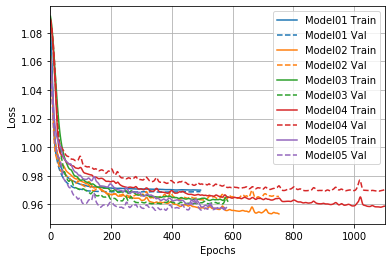

In [8]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(size_histories)


Text(0.5, 0, 'Epochs [Log Scale]')

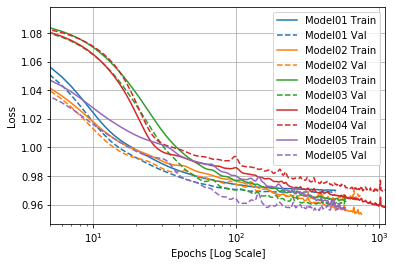

In [9]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

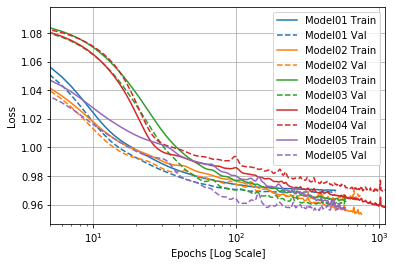

In [10]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

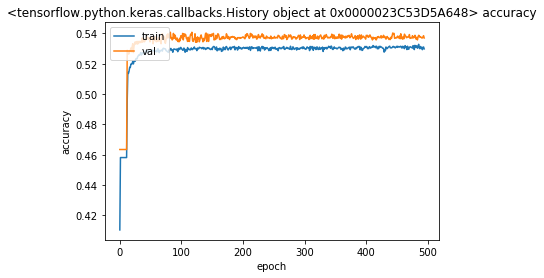

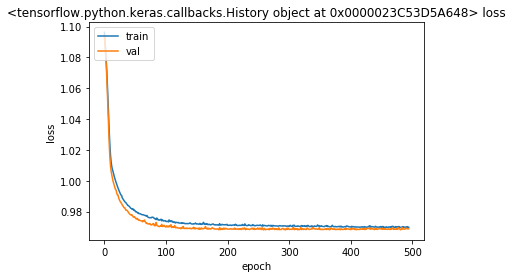

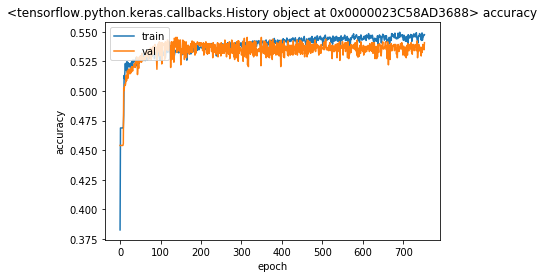

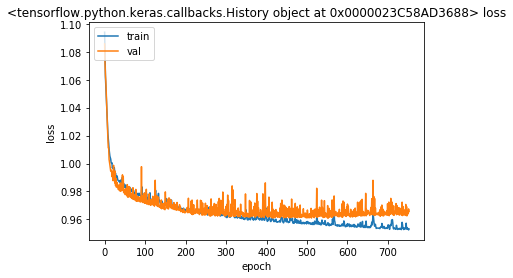

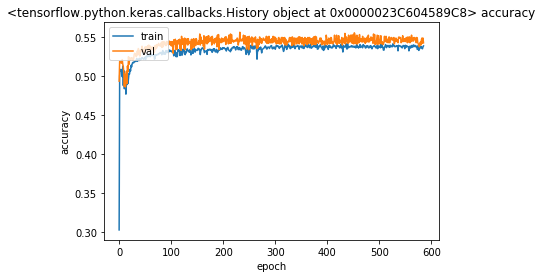

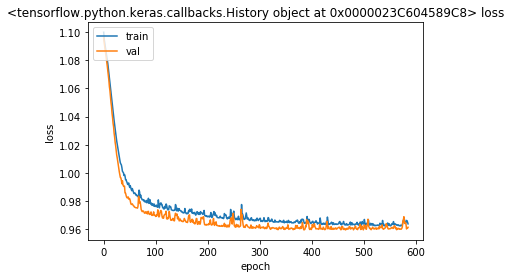

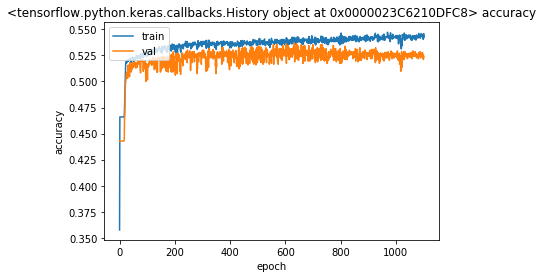

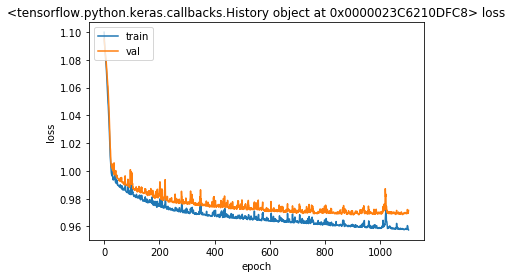

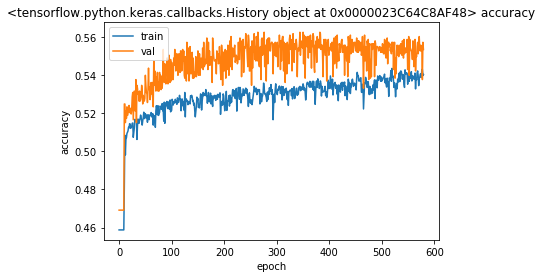

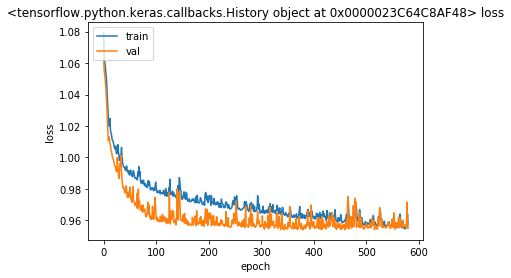

In [11]:
plot_history(size_histories['model01'])
plot_history(size_histories['model02'])
plot_history(size_histories['model03'])
plot_history(size_histories['model04'])
plot_history(size_histories['model05'])

In [12]:
score = load_model('../model/martin_model01.h5').evaluate(test_X01, test_y01, verbose=3)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("#####")

score = load_model('../model/martin_model02.h5').evaluate(test_X02, test_y02, verbose=3)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("#####")

score = load_model('../model/martin_model03.h5').evaluate(test_X03, test_y03, verbose=3)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("#####")

score = load_model('../model/martin_model04.h5').evaluate(test_X04, test_y04, verbose=3)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("#####")

score = load_model('../model/martin_model05.h5').evaluate(test_X05, test_y05, verbose=3)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("#####")


Test Score: 0.9784467357591566
Test Accuracy: 0.5393474
#####
Test Score: 0.9985063346949491
Test Accuracy: 0.5113636
#####
Test Score: 0.9796081943945452
Test Accuracy: 0.5255682
#####
Test Score: 0.970786578314645
Test Accuracy: 0.5228571
#####
Test Score: 1.013617993082319
Test Accuracy: 0.52
#####
